In [11]:
import numpy as np
import pandas as pd
import time
import matplotlib.pylab as plt
from Data_Loading import *
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer, StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer

In [49]:
mod = KNeighborsRegressor()

mod.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': 1,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [37]:
main_df = pd.read_csv('Banco de Dados/atributos/atributos_main.csv')

resultados = {}

In [24]:
X = main_df.iloc[:, 2:68]
y = main_df.iloc[:, 68]
X_train, X_test, y_train, y_test = train_test_split(X, y)


In [52]:
pipe = Pipeline([
    ('scale', StandardScaler()),
    ('model', MLPRegressor(max_iter = 1000))
])

pipe2 = Pipeline([
    ("scale", QuantileTransformer()),
    ("model", mod)
])

#pipe2.fit(X_train, y_train)

#pred = pipe2.predict(X_test)

#resultados['KNN com QuantileTransformer - MSE'] = mean_squared_error(pred, y_test)
#resultados['KNN com QuantileTransformer - MAE'] = mean_absolute_error(pred, y_test)
print(resultados)

{'MLP com QuantileTransformer - MSE': 1092.2771696257248, 'MLP com QuantileTransformer - MAE': 25.29588132175929, 'Linear Regression com QuantileTransformer - MSE': 1080.7416035553954, 'Linear Regression com QuantileTransformer - MAE': 25.40405431302265, 'Linear Regression com StandardScaler - MSE': 1097.5678570242765, 'Linear Regression com StandardScaler - MAE': 25.422403483361645, 'KNN com StandardScaler - MSE': 1144.7507968403113, 'KNN com StandardScaler - MAE': 23.931452021660647, 'KNN com QuantileTransformer - MSE': 1120.7774958120742, 'KNN com QuantileTransformer - MAE': 23.796974849578824}


In [53]:
#list_of_sizes = [(5,), (11,), (16,), (22,), (5,5), (11, 11), (16, 11), (22, 16), (22, 16, 11)]
list_of_sizes = [(5,), (5,5), (5,5,5)]

start = time.time()
grid = GridSearchCV(estimator = pipe,
                   param_grid = {'model__alpha': [0.001, 0.003, 0.01, 0.03, 0.1, 0.3], 
                                'model__hidden_layer_sizes': list_of_sizes,
                                'model__learning_rate_init': [0.001, 0.003, 0.01, 0.03, 0.1, 0.3]},
                   scoring = {'mse': make_scorer(mean_squared_error), 'mae': make_scorer(mean_absolute_error)},
                   refit='mse',
                   cv=5,
                   n_jobs=-1)

grid.fit(X_train, y_train)
end = time.time()
print(f'Tempo decorrido: {end-start} segundos = {(end-start)/60} minutos')

Tempo decorrido: 740.6829061508179 segundos = 12.34471510251363 minutos


In [ ]:
df = pd.DataFrame(grid.)

1064.2433835254894
24.272758376723342


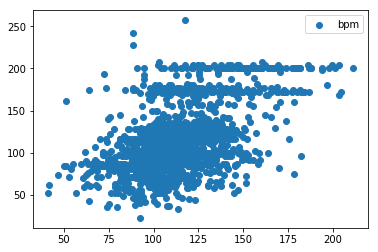

In [54]:
pred = grid.predict(X_test)

print(mean_squared_error(pred, y_test))

plt.scatter(pred, y_test);

plt.legend();

resultados['MLP com StandardScaler - MSE'] = mean_squared_error(pred, y_test)
resultados['MLP com StandardScaler - MAE'] = mean_absolute_error(pred, y_test)
print(mean_absolute_error(pred, y_test))

In [44]:
df = pd.DataFrame(grid.cv_results_)
df.loc[df['rank_test_mse'] == 1]

C:\DevSoft\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_mse'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\DevSoft\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_mse'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\DevSoft\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_mse'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\DevSoft\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:122: Futu

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__alpha,param_model__hidden_layer_sizes,param_model__learning_rate_init,params,split0_test_mse,split1_test_mse,...,mean_test_mae,std_test_mae,rank_test_mae,split0_train_mae,split1_train_mae,split2_train_mae,split3_train_mae,split4_train_mae,mean_train_mae,std_train_mae
72,18.571742,6.59404,0.290697,0.018023,0.1,"(5,)",0.001,"{'model__alpha': 0.1, 'model__hidden_layer_siz...",10526.52253,1129.194437,...,39.872855,27.664388,1,96.392113,25.014153,25.445187,26.834048,25.231919,39.783484,28.311456


In [ ]:
indices = np.random.permutation(len(main_df))

main_train = main_df.iloc[indices[:-1329]]
main_test = main_df.iloc[indices[-1329:]]

x_train = main_train.iloc[:, 1:67].values
y_train = main_train.iloc[:, 67].values
x_test = main_test.iloc[:, 1:67].values
y_test = main_test.iloc[:, 67].values

In [ ]:
regr.fit(x_train, y_train)

regr.score(x_test, y_test)

In [ ]:
prediction = regr.predict(x_test)

total = len(prediction)
certo1 = 0
certo2 = 0
certo3 = 0
e = 0
for i in range(len(prediction)):
    x = prediction[i]
    y = y_test[i]
    
    if x==y:
        print('oi')
        certo1+=1
        certo2+=1
        certo3+=1
    elif x/y>0.959 and x/y<1.041:
        certo2+=1
        certo3+=1
    elif 4*x/y>0.959 and 4*x/y<1.041:
        certo3+=1
    elif 2*x/y>0.959 and 2*x/y<1.041:
        certo3+=1
    elif x/(y*2)>0.959 and x/(y*2)<1.041:
        certo3+=1
    elif x/(y*4)>0.959 and x/(y*4)<1.041:
        certo3+=1
    
    e += abs(x/y-1)
        
acc1 = 100*certo1/total
acc2 = 100*certo2/total
acc3 = 100*certo3/total
e = 100*e/total

print(f'Acuracia 1: {acc1}%;    Acuracia 2: {acc2}%;    Acuracia 3: {acc3}%;    Erro Médio: {e}%')

In [ ]:
x_train_df = main_train.iloc[:, 1:67]
y_train_df = main_train.iloc[:, 67]
x_test_df = main_test.iloc[:, 1:67]
y_test_df = main_test.iloc[:, 67]

x_train_df.to_csv('Banco de Dados/best_x_train.csv')
x_test_df.to_csv('Banco de Dados/best_x_test.csv')
y_train_df.to_csv('Banco de Dados/best_y_train.csv')
y_test_df.to_csv('Banco de Dados/best_y_test.csv')